# LiberTEM-Holo : Line Mask Example
This code below provides an example, focus on creating line mask to reduce fresnel fringes.

### Getting Started
These first few cells below are preparatory: importing the necessary python libraries and function, loading and preparing the input data.
In this example the input data is formatted as .dm4.

In [2]:
#Import necessary Libaries and Function
%matplotlib nbagg 
import numpy as np
from ncempy.io.dm import fileDM  #package to load DM file
import matplotlib.pyplot as plt 
from skimage.restoration import unwrap_phase
from scipy.signal import fftconvolve
from skimage.filters import window
import empyre as emp

#LiberTem-Holo Package
from libertem_holo.base.reconstr import (reconstruct_frame,
                                         get_slice_fft,
                                         estimate_sideband_position,
                                         estimate_sideband_size)
from libertem_holo.base.mask import disk_aperture, line_filter
from libertem_holo.base.filters import clipped, window_filter

In [3]:
#Loading data from DM4 file
with fileDM ('/cachedata/users/gunawan/04_alpha+0_obj.dm4') as f:
    data = f.getDataset(0)
with fileDM ('/cachedata/users/gunawan/05_alpha+0_ref.dm4') as f:
    data_ref = f.getDataset(0)
    
image_original = data['data'][0] #the input data contain one stack of Images, in this example only one of the images is used
image_reference = data_ref['data'][0] #image reference for better reconstruction

It is recomended to see the original input data before reconstruction to have a better understanding the effect of the reconstruction with the package

<IPython.core.display.Javascript object>


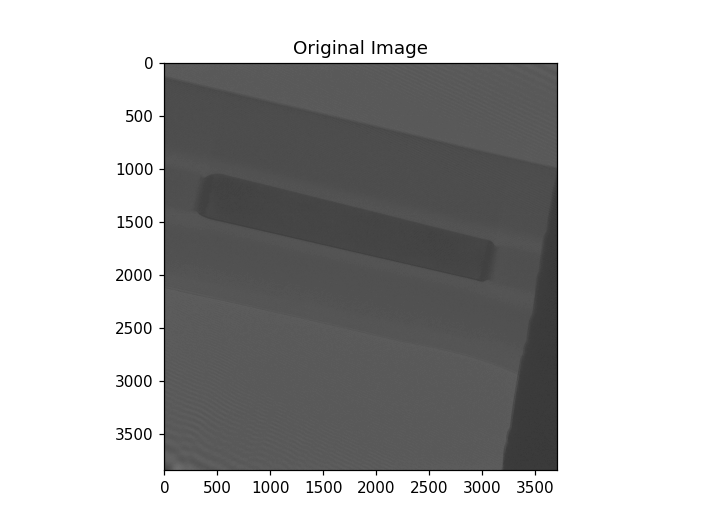

<IPython.core.display.Javascript object>


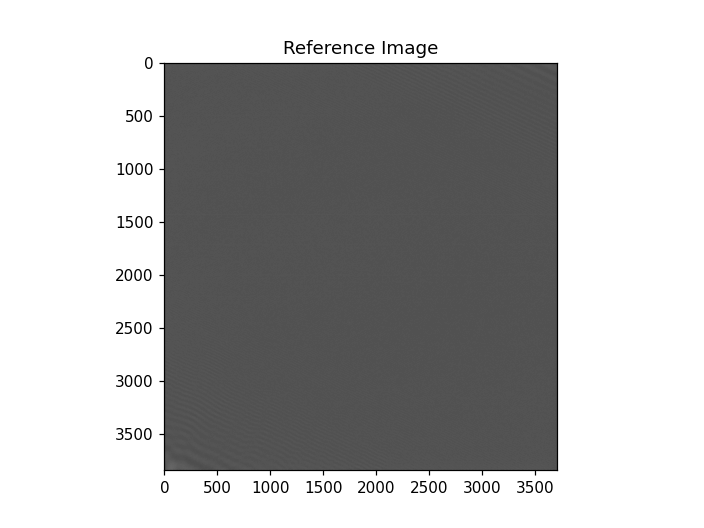

Text(0.5, 1.0, 'Reference Image')

In [4]:
plt.figure()
plt.imshow(image_original, vmax=np.max(clipped(image_original)), cmap="gray")
plt.title('Original Image')
plt.figure()
plt.imshow(image_reference, vmax=np.max(clipped(image_reference)), cmap="gray")
plt.title('Reference Image')

### Creating an Aperture
For the purpose of reconstruction, it is necessary to create an Aperture. The requirements to create an aperture are the position of the sideband and the size of the sideband. 

#### Estimation of the sideband's position and size
In the liberTEM-Holo package, there are two functions to estimate the position and the size of the sideband. Here the reference image is used to defined the sideband's position and size.

In [5]:
#estimate the position of the sidebands
sb_position = estimate_sideband_position(image_reference,holo_sampling=(1,1))
#estimate the size of the sidebands
sb_size= estimate_sideband_size(sb_position,
                                image_reference.shape,
                                sb_size_ratio=0.5)

#### Creating aperture and slice_fft
After the sideband's size is estimated, the aperture is created with get_aperture function. The slice_fft is needed later for the reconstruct_frame function

In [6]:
#Before using the get_aperture or get_aperture_gauss function, the size of the output need to be defined 
out_shape = (1024,1024)

#Create an Aperture and an array for slice_fft
aperture = disk_aperture(out_shape=out_shape, radius=sb_size)
slice_fft = get_slice_fft(out_shape=out_shape, sig_shape=image_reference.shape)

### Creating Line Mask with Line Filter
The line mask is required to remove the fresnel fringes. The line mask will be combined later on with aperture.

In [7]:
line_mask = line_filter(image_original.shape,
                        sidebandpos=sb_position,
                        width=50,
                        length=580,
                        slice_fft=slice_fft)

# Combine the aperture with the line mask
aperture_mask = aperture*line_mask

#### Filtering the aperture
To get a better result, it is recommended to filter the aperture. The function window_filter have some different windows type, which are listed below:
- boxcar
- triang
- blackman
- hamming
- hann
- bartlett
- flattop
- parzen
- bohman
- blackmanharris
- nuttall
- barthann
- kaiser (needs beta)
- gaussian (needs standard deviation)
- general_gaussian (needs power, width)
- slepian (needs width) - dpss (needs normalized half-bandwidth)
- chebwin (needs attenuation)
- exponential (needs decay scale)
- tukey (needs taper fraction)

Some window types need an extra value to be written in the window type.

<IPython.core.display.Javascript object>


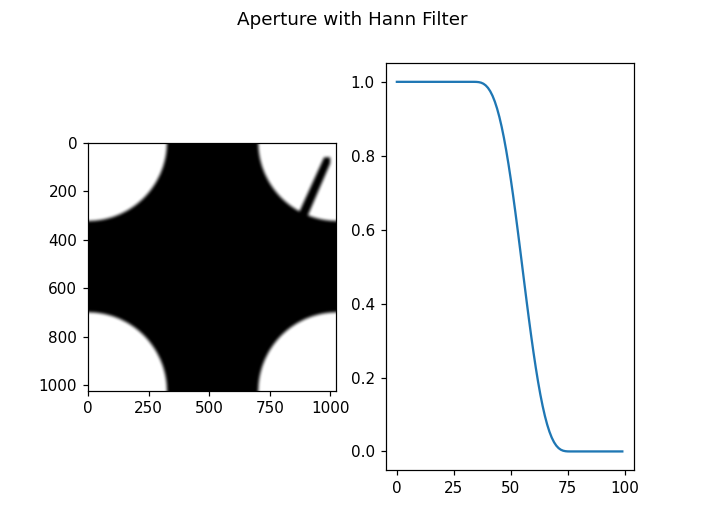

In [8]:
# Hann Filter
aperture_mask_filtered = window_filter(aperture_mask, 'hann', 35) 

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Aperture with Hann Filter')
ax1.imshow(aperture_mask_filtered, cmap="gray")
ax2.plot(aperture_mask_filtered[200,200:300])

it is important to check, whether the line filter covered the correct area. Therefore it is recommended to display the fft of the original image multiply with the aperture mask.

<IPython.core.display.Javascript object>


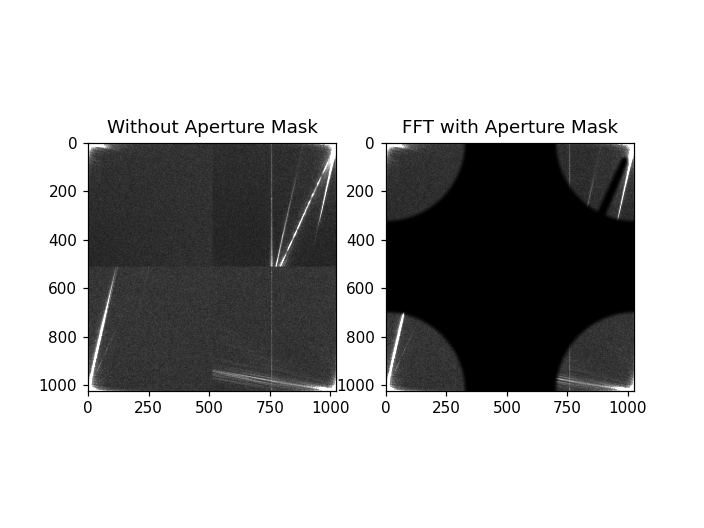

Text(0.5, 1.0, 'FFT with Aperture Mask')

In [9]:
# Preparation of the fft original image. 
fft_original_image = np.fft.fft2(image_original) / np.prod(image_original.shape)
fft_original_image = np.roll(fft_original_image, sb_position, axis=(0, 1))
fft_original_image = np.fft.fftshift(np.fft.fftshift(fft_original_image)[slice_fft])
fft_with_aperture = fft_original_image * aperture_mask_filtered

figure, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(fft_original_image), vmax=0.01, cmap="gray")
ax1.set_title('Without Aperture Mask')

ax2.imshow(np.abs(fft_with_aperture), vmax=0.01, cmap="gray")
ax2.set_title('FFT with Aperture Mask')

### Reconstruction
The reconstruction is done by using the reconstruct_frame function. Both of the original image and reference image are reconstructed. After the reconstruction, the original image is divided by the reference image. 
In this example, the difference caused by line filter is shown in the figure below.

In [10]:
# Reconstruction without line filter
aperture_filtered = window_filter(aperture, 'hann', 35)
# Reconstruction of original image
wav_original1 = reconstruct_frame(image_original, 
                                 sb_pos=sb_position, 
                                 slice_fft=slice_fft, 
                                 aperture=aperture_filtered)
                                

# Reconstruction of reference image
wav_reference1 = reconstruct_frame(image_reference,
                                 sb_pos=sb_position, 
                                 slice_fft=slice_fft, 
                                 aperture=aperture_filtered)
#Correction with the reference image
wav_final1 = wav_original1/wav_reference1

# Reconstruction with line filter
# Reconstruction of original image with line filter
wav_original2 = reconstruct_frame(image_original, 
                                 sb_pos=sb_position, 
                                 slice_fft=slice_fft, 
                                 aperture=aperture_mask_filtered)
                                

#reconstruction of reference image with line filter
wav_reference2 = reconstruct_frame(image_reference,
                                 sb_pos=sb_position, 
                                 slice_fft=slice_fft, 
                                 aperture=aperture_mask_filtered)
#Correction with the reference image
wav_final2 = wav_original2/wav_reference2
                                 

<IPython.core.display.Javascript object>


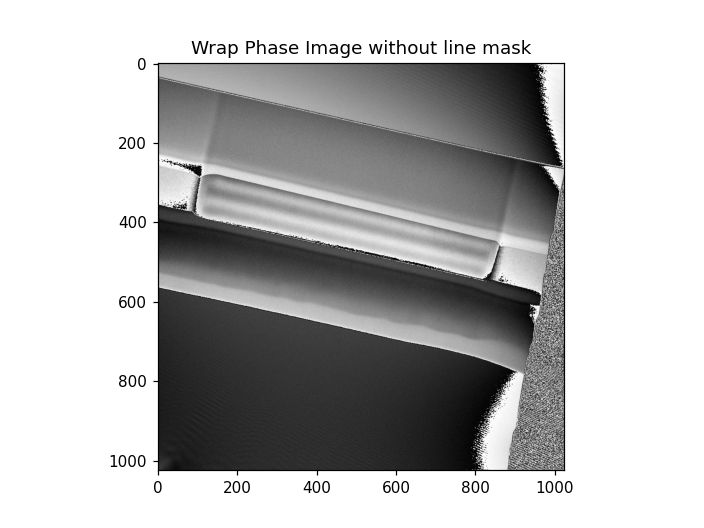

<IPython.core.display.Javascript object>


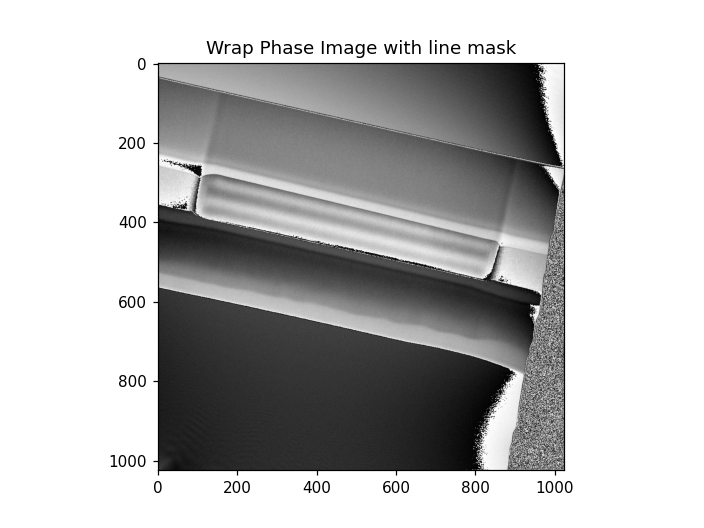

<IPython.core.display.Javascript object>


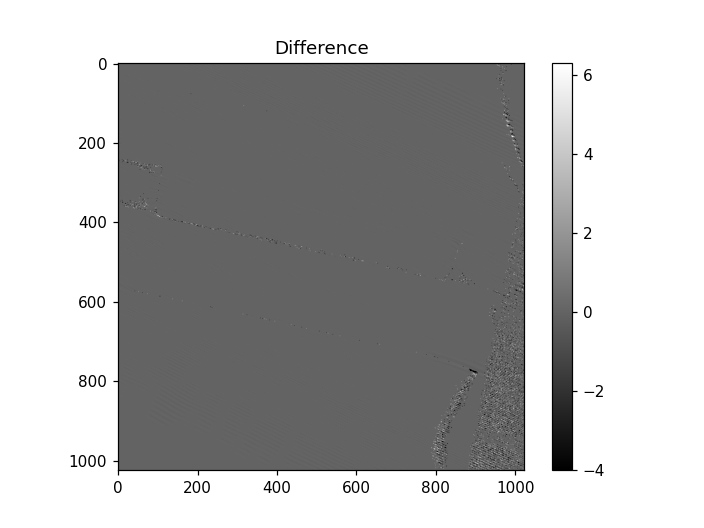

In [11]:
plt.figure()
plt.imshow(np.angle(wav_final1), cmap="gray")
plt.title('Wrap Phase Image without line mask')
plt.figure()
plt.imshow(np.angle(wav_final2), cmap="gray")
plt.title('Wrap Phase Image with line mask')
plt.figure()
plt.imshow(np.angle(wav_final1)-np.angle(wav_final2), vmin=-4, cmap="gray")
plt.title('Difference')
plt.colorbar()

<IPython.core.display.Javascript object>


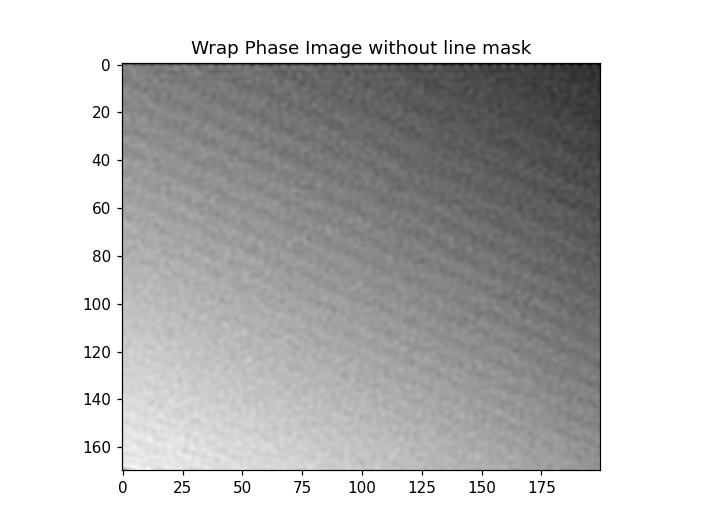

<IPython.core.display.Javascript object>


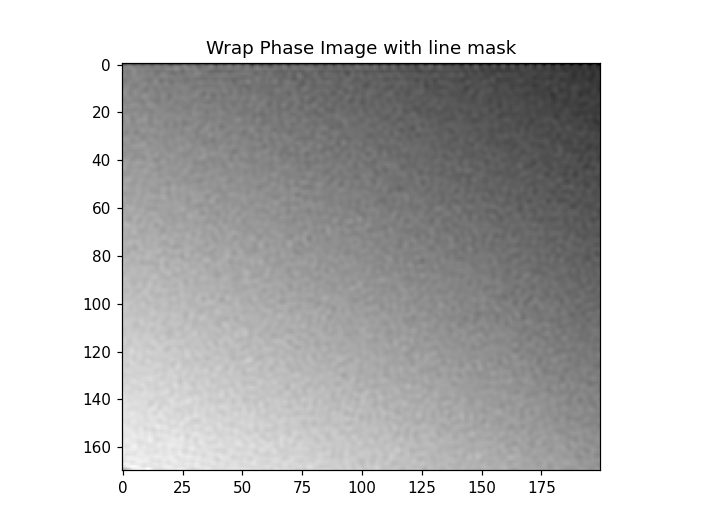

Text(0.5, 1.0, 'Wrap Phase Image with line mask')

In [15]:
# Display specific ROI to show the fresnel 
plt.figure()
plt.imshow(np.angle(wav_final1)[0:170,600:800], cmap="gray")
plt.title('Wrap Phase Image without line mask')
plt.figure()
plt.imshow(np.angle(wav_final2)[0:170,600:800], cmap="gray")
plt.title('Wrap Phase Image with line mask')

### Unwrapping
The unwrapping is done by using skimage.restoration.unwrap_phase. For a better display, a mask is created to mask out the noise in the bottom left area. The minimum value and maximal value for vmin and vmax is calculated with numpy min and numpy max of the image without the noisy area.

<IPython.core.display.Javascript object>


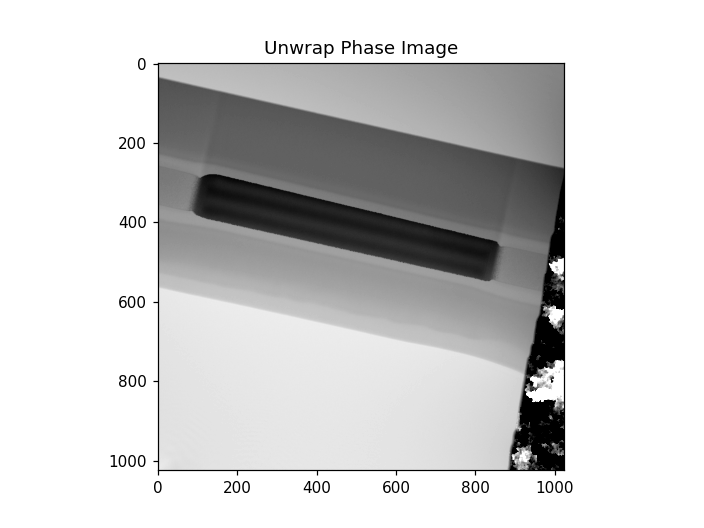

Text(0.5, 1.0, 'Unwrap Phase Image')

In [17]:
#unwrapping
unwrap_phase_image = unwrap_phase(np.angle(wav_final2))

#creating mask with skimage draw_polygon
from skimage.draw import polygon
r = np.array([270, 1023 , 1023])
c = np.array([1023, 1023, 875])
rr, cc = polygon(r, c)
mask_roi = np.ones((1024,1024))
mask_roi[rr, cc] = 0

#calculating vmin, vmax
vmin = np.min(unwrap_phase_image*mask_roi)
vmax = np.max(unwrap_phase_image*mask_roi)

plt.figure()
plt.imshow(unwrap_phase_image, vmin=vmin, vmax=vmax, cmap="gray")
plt.title('Unwrap Phase Image')


### Advanced plotting
Plot the curl and the cosine contour with empyre package.
The documentation of the empyre could be find in the link below:
https://empyre.iffgit.fz-juelich.de/empyre/vis.html

<IPython.core.display.Javascript object>


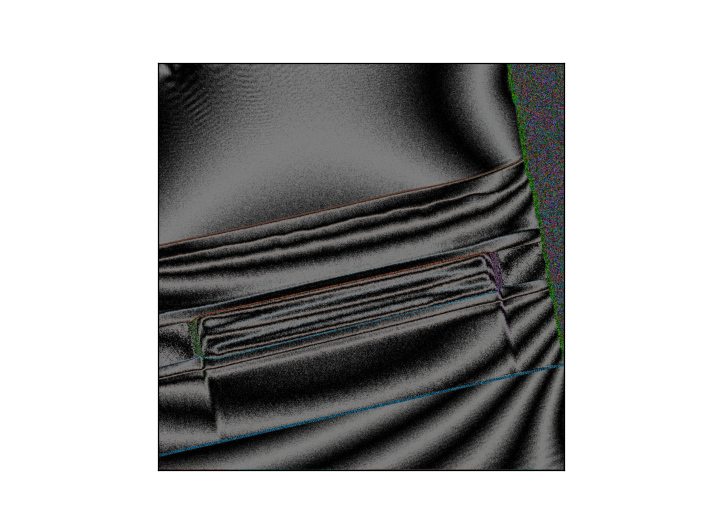

In [18]:
# Represent the unwrap phase image with the 'field' class
phase_field= emp.fields.Field(data=unwrap_phase_image, scale=1, vector=False)
cmap = emp.vis.colors.cmaps.cyclic_cubehelix
plt.figure()
#Display the curl
emp.vis.colorvec(phase_field.curl().clip(sigma=1), vmin=vmin, vmax=vmax, cmap=cmap)
#Display the cosine contours
emp.vis.cosine_contours(phase_field, gain = 5)